In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%load_ext watermark

# Volatility Forecasting

## Explaining stock returns' volatility with ARCH models

### How to do it...

1. Import the required libraries:

In [4]:
import pandas as pd
import yfinance as yf
from arch import arch_model

In [5]:
%watermark --iversions

yfinance   0.1.42
matplotlib 3.0.3
json       2.0.9
pandas     0.24.2
numpy      1.16.2
autopep8   1.4.4



2. Specify the risky asset and the time horizon:

In [6]:
RISKY_ASSET = 'GOOG'
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [7]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 downloaded
Downloaded 1006 rows of data.


4. Calculate daily returns:

Average return: 0.08%


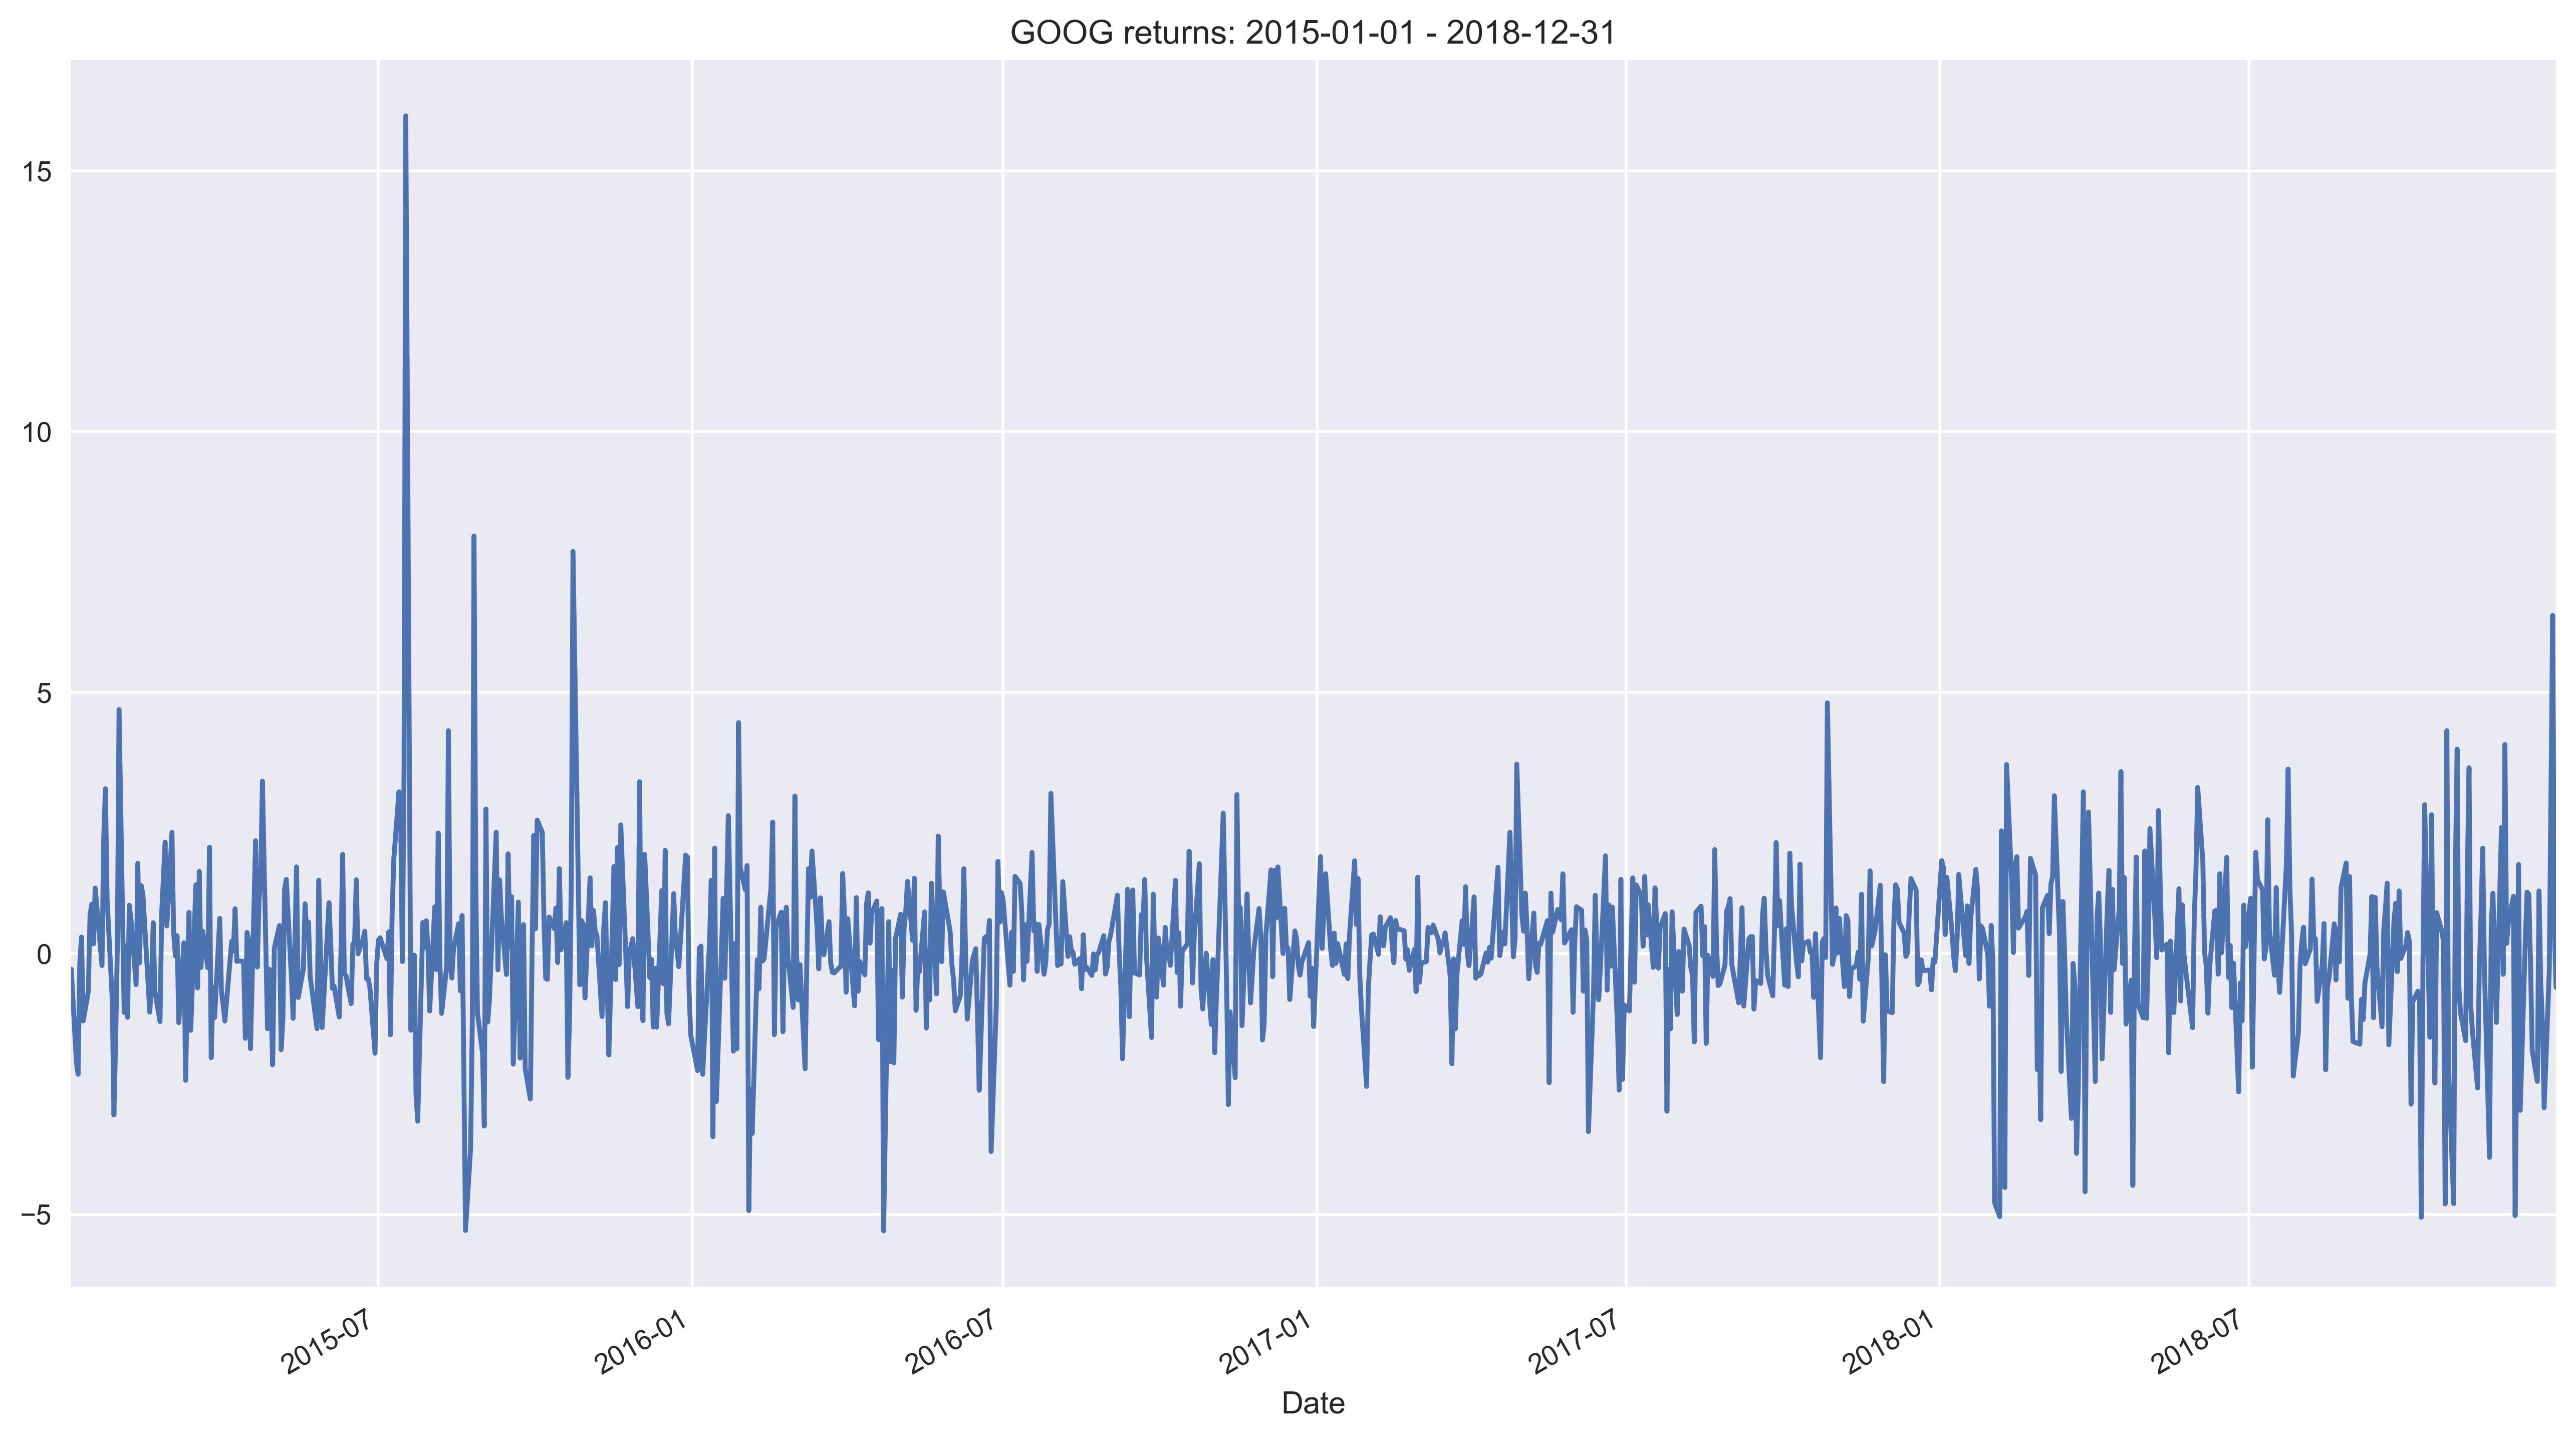

In [8]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}');

5. Specify the ARCH model:

In [9]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)

6. Estimate the model and print the summary:

In [10]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1800.60
Distribution:                  Normal   AIC:                           3605.20
Method:            Maximum Likelihood   BIC:                           3615.02
                                        No. Observations:                 1005
Date:                Tue, Sep 03 2019   Df Residuals:                     1003
Time:                        22:44:02   Df Model:                            2
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.6323      0.167      9.794  1.196e-22   [  1.30

7. Plot the residuals and the conditional volatility:

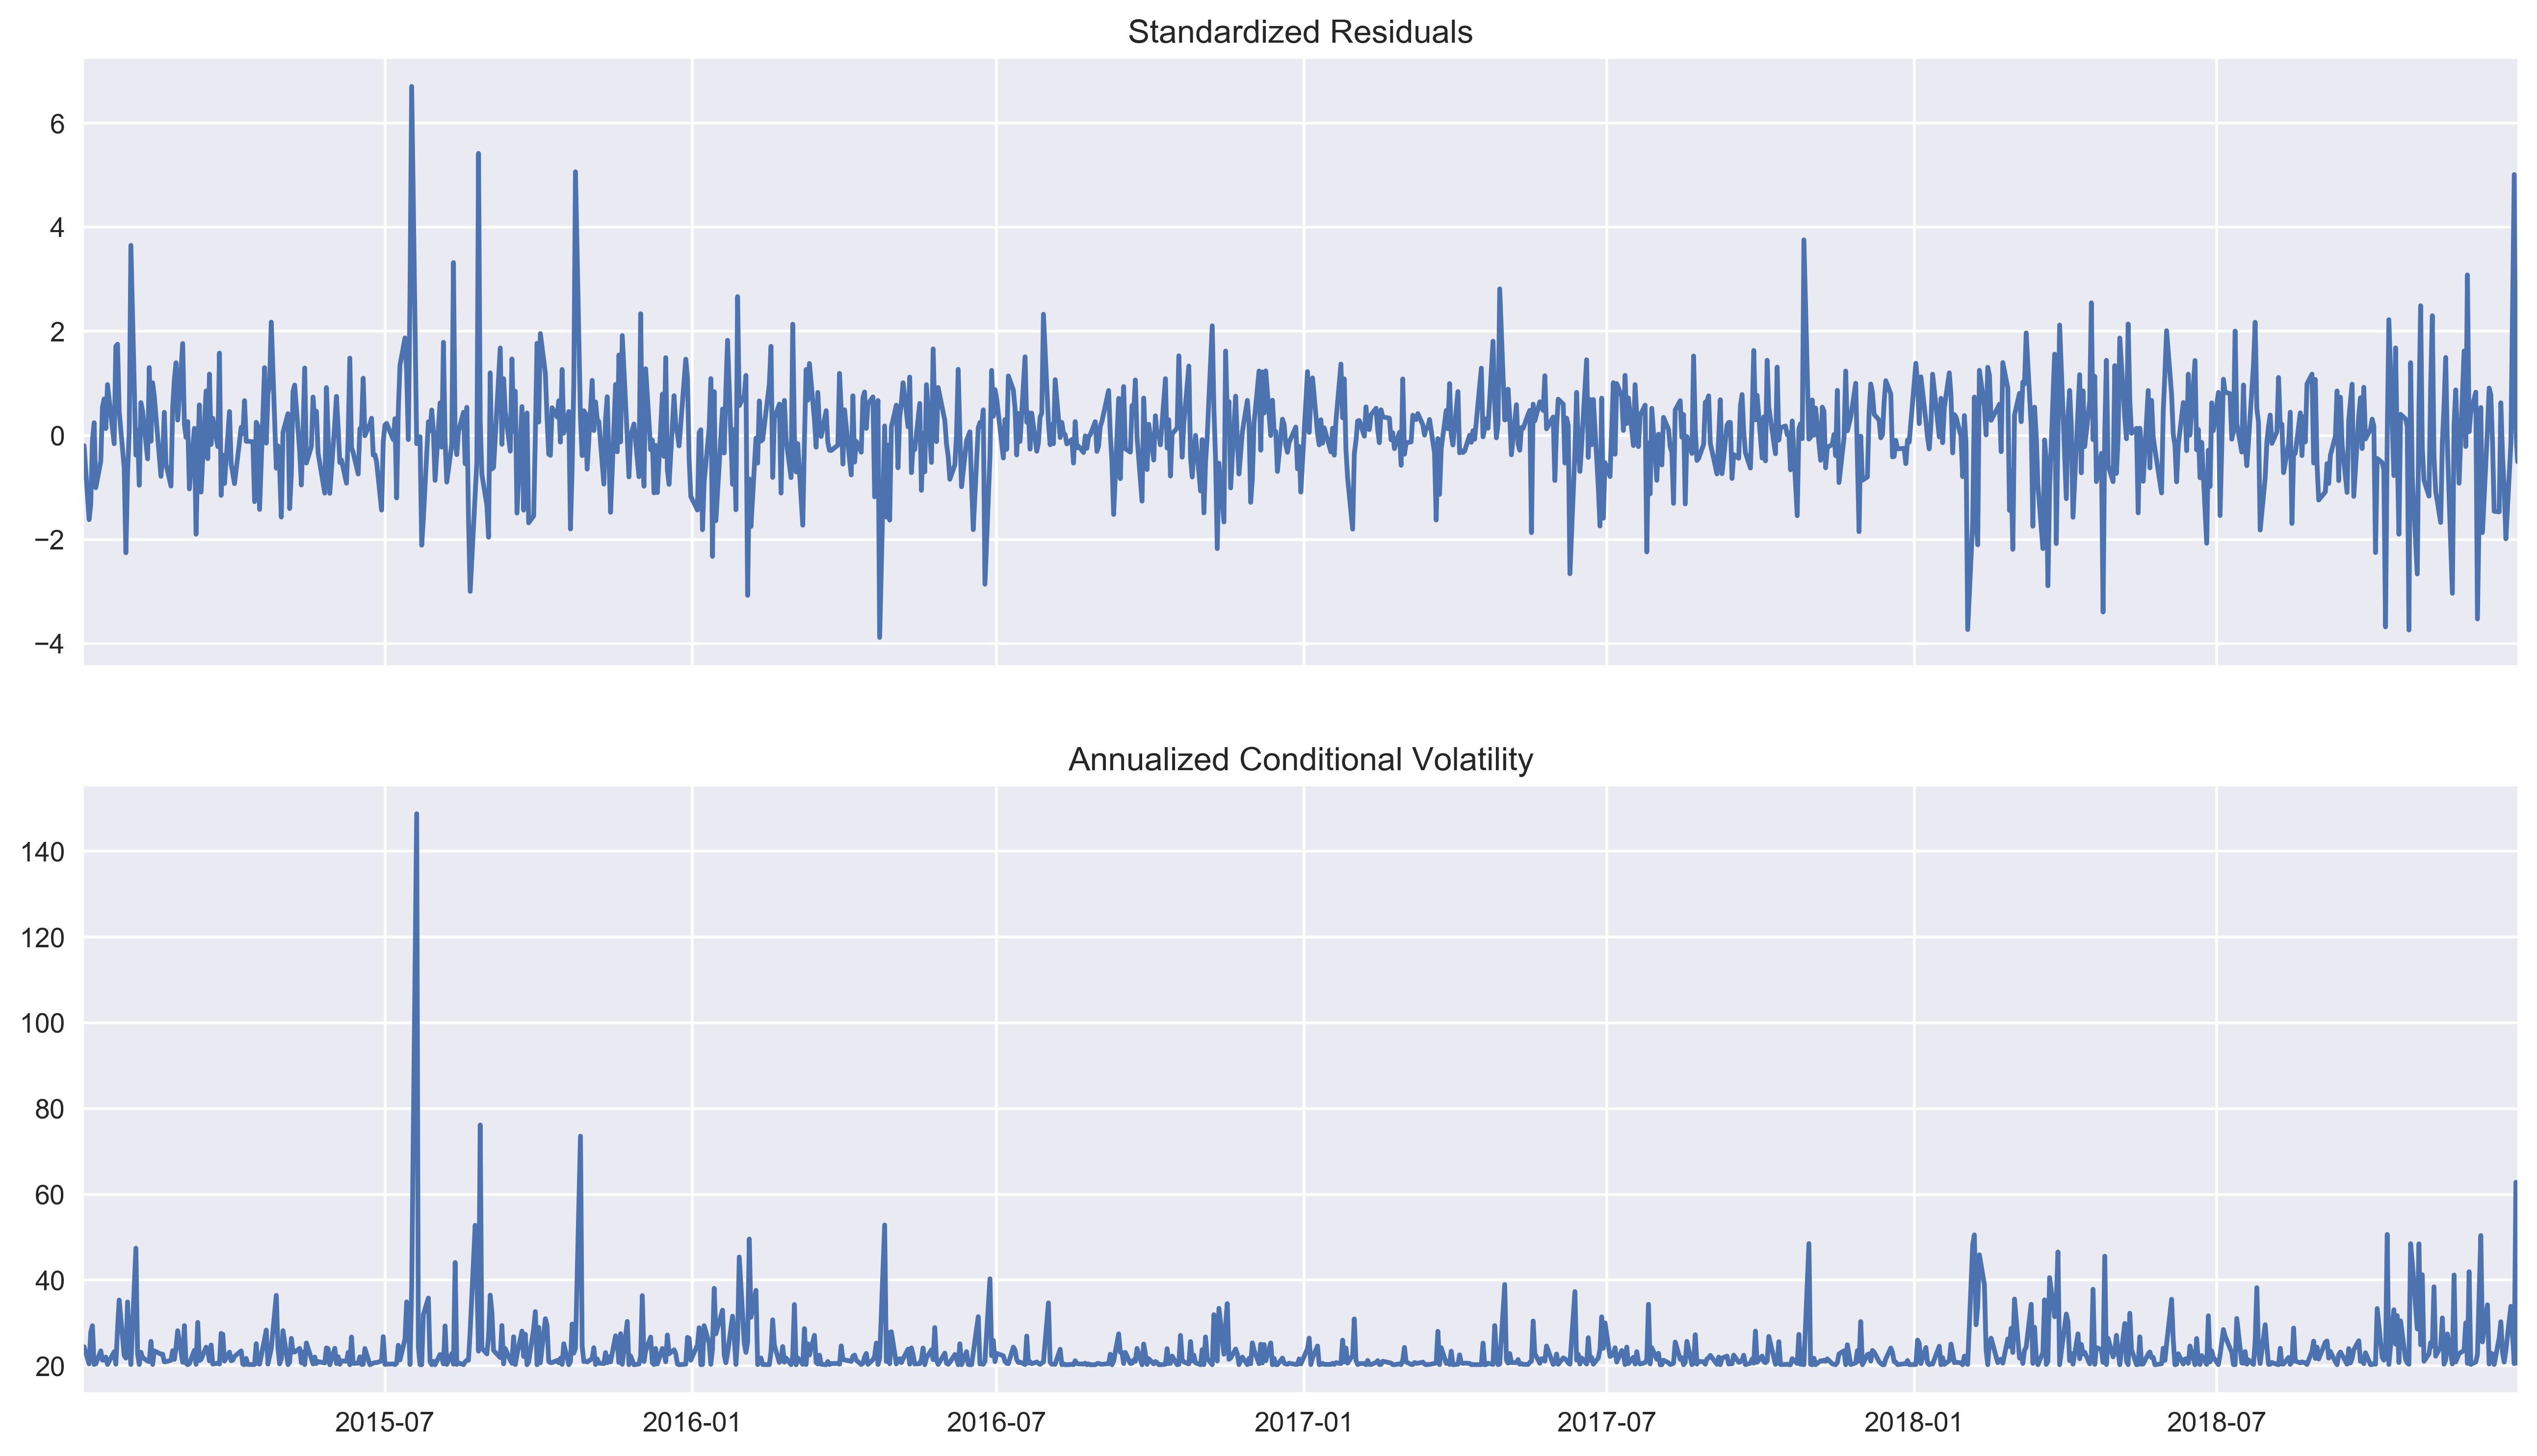

In [11]:
model_fitted.plot(annualize='D');

## Explaining stock returns' volatility with GARCH models

### How to do it...

1. Specify the GARCH model:

In [12]:
model = arch_model(returns, mean='Zero', vol='GARCH', p=1, o=0, q=1)

2. Estimate the model and print the summary:

In [13]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1764.88
Distribution:                  Normal   AIC:                           3535.76
Method:            Maximum Likelihood   BIC:                           3550.50
                                        No. Observations:                 1005
Date:                Tue, Sep 03 2019   Df Residuals:                     1002
Time:                        22:44:14   Df Model:                            3
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1781      0.157      1.134      0.257    [ -

3. Plot the residuals and the conditional volatility:

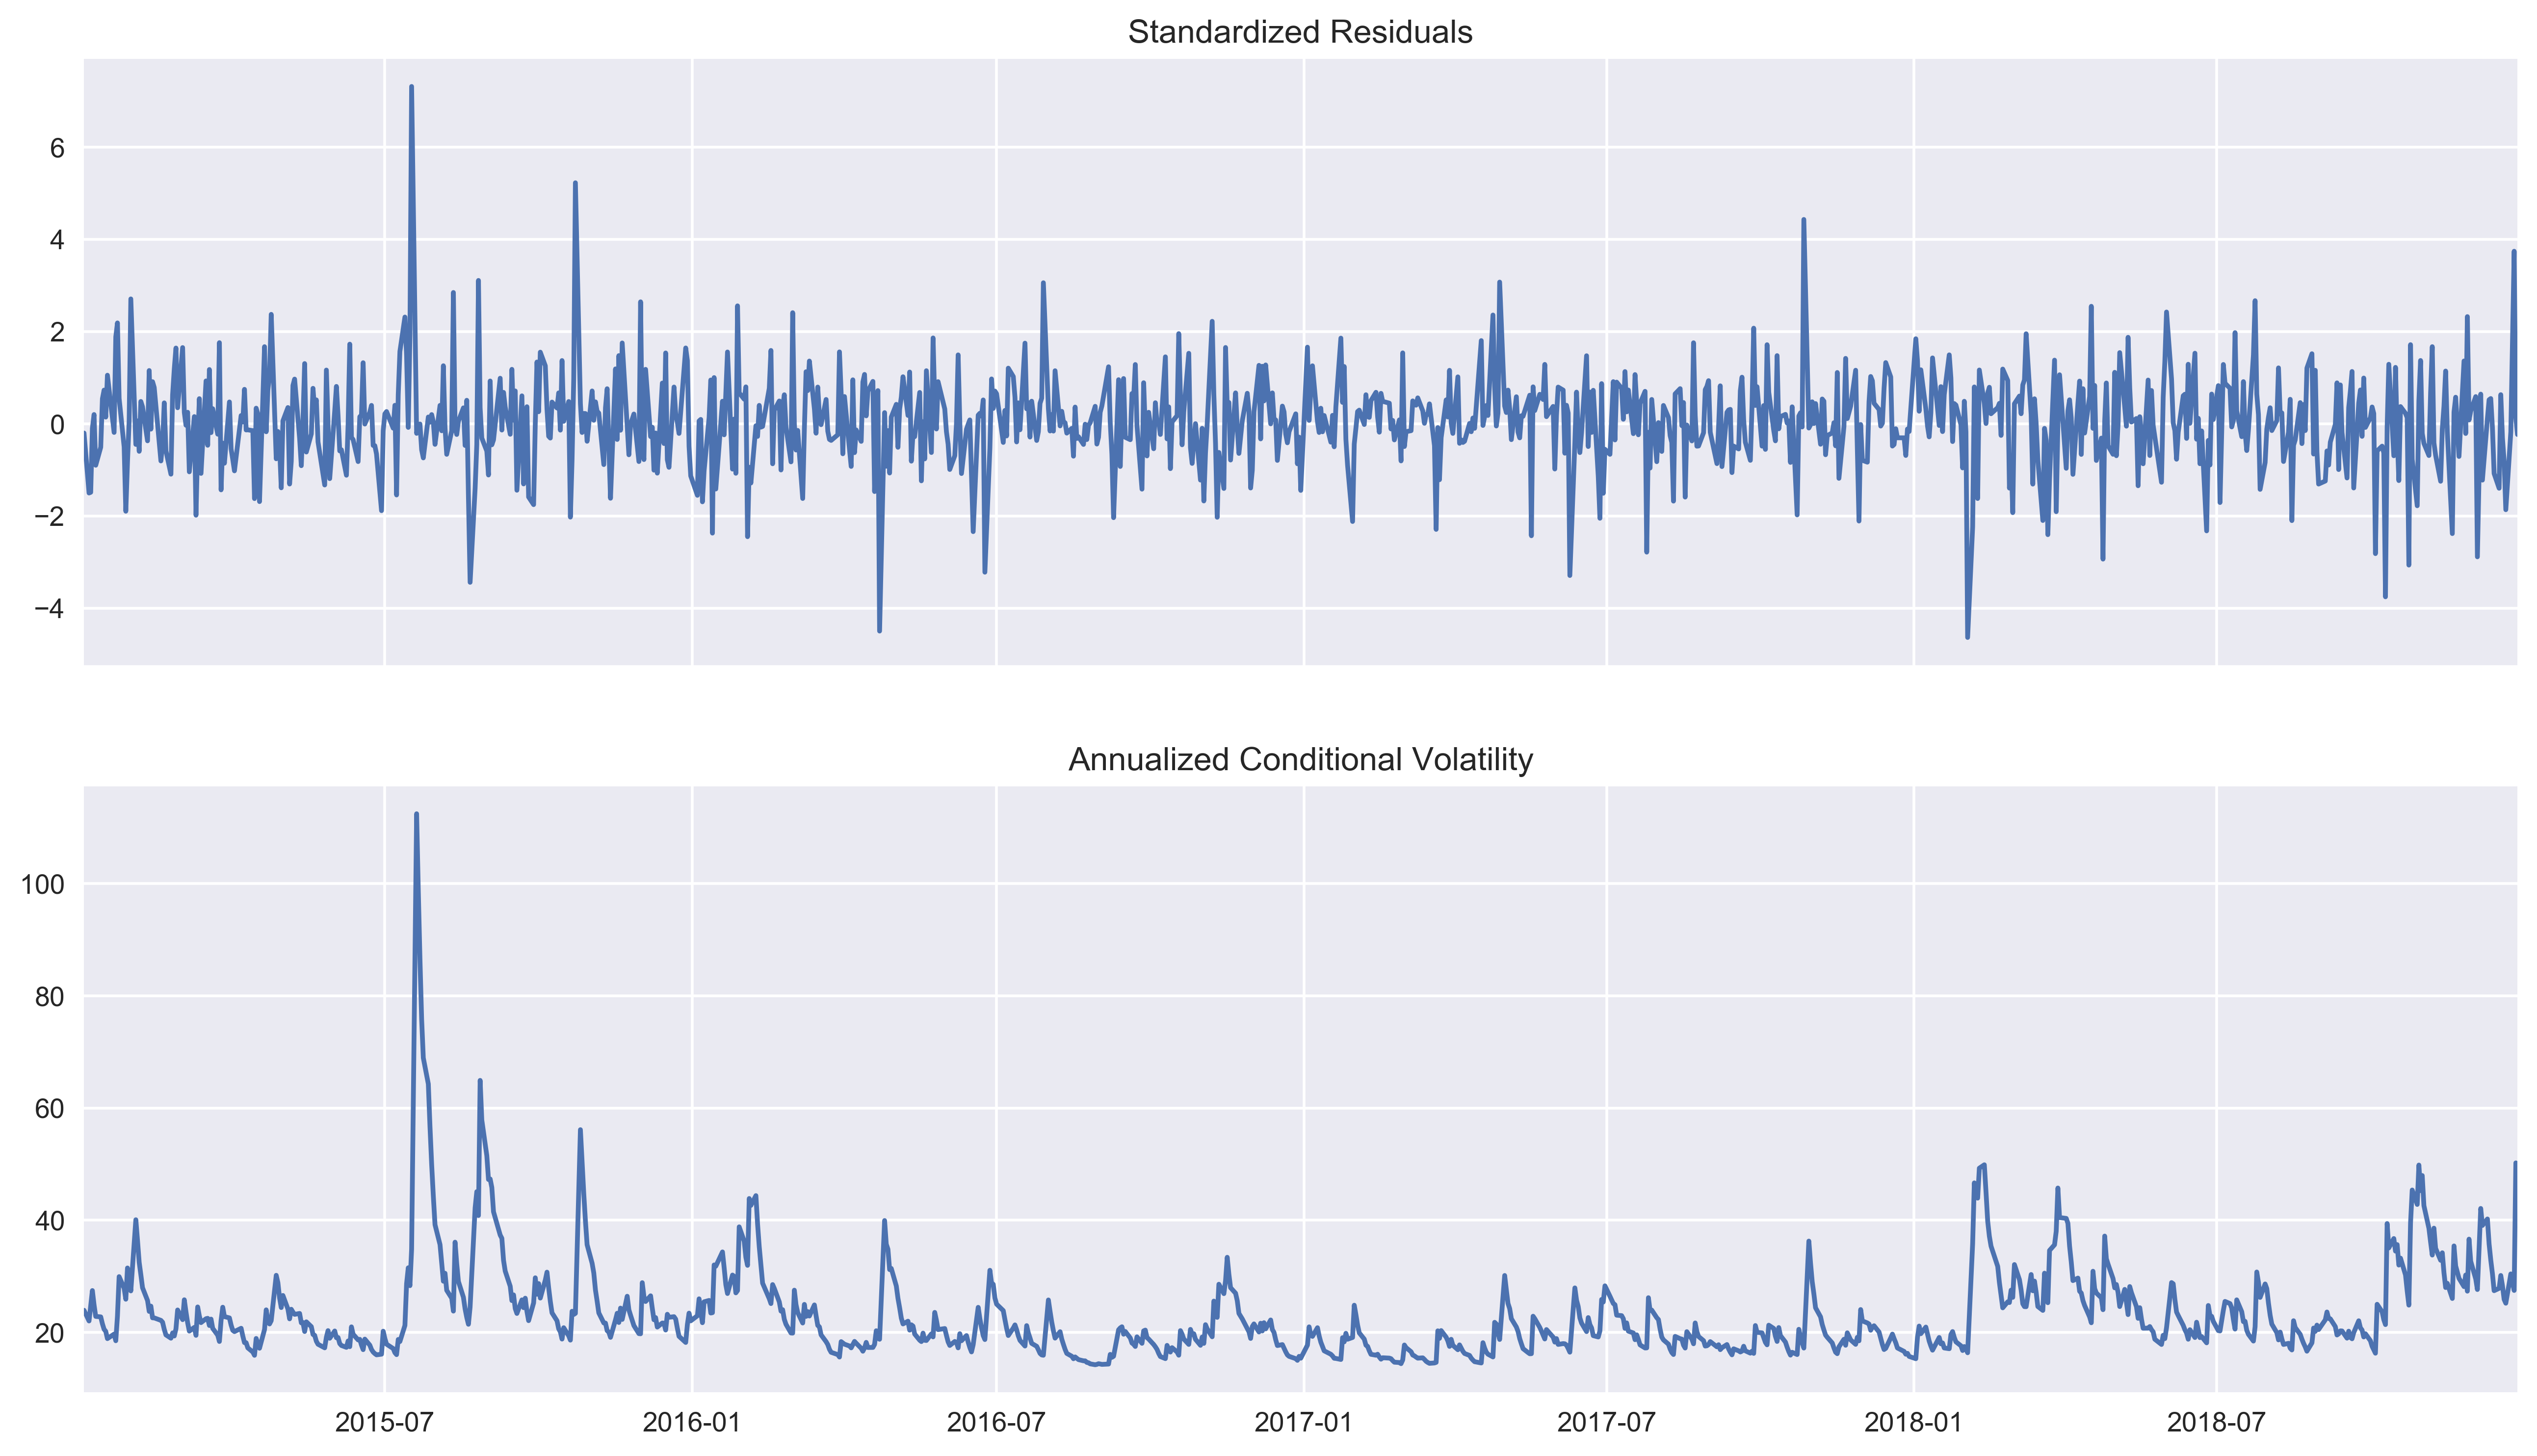

In [14]:
model_fitted.plot(annualize='D');

## Implementing CCC-GARCH model for multivariate volatility forecasting

### How to do it...

1. Import the required libraries:

In [15]:
import pandas as pd
import yfinance as yf
from arch import arch_model

In [16]:
%watermark --iversions

yfinance   0.1.42
matplotlib 3.0.3
json       2.0.9
pandas     0.24.2
numpy      1.16.2
autopep8   1.4.4



2. Specify the risky asset and the time horizon:

In [17]:
RISKY_ASSETS = ['GOOG', 'MSFT', 'AAPL']
N = len(RISKY_ASSETS)
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [18]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 downloaded
Downloaded 1006 rows of data.


4. Calculate daily returns:

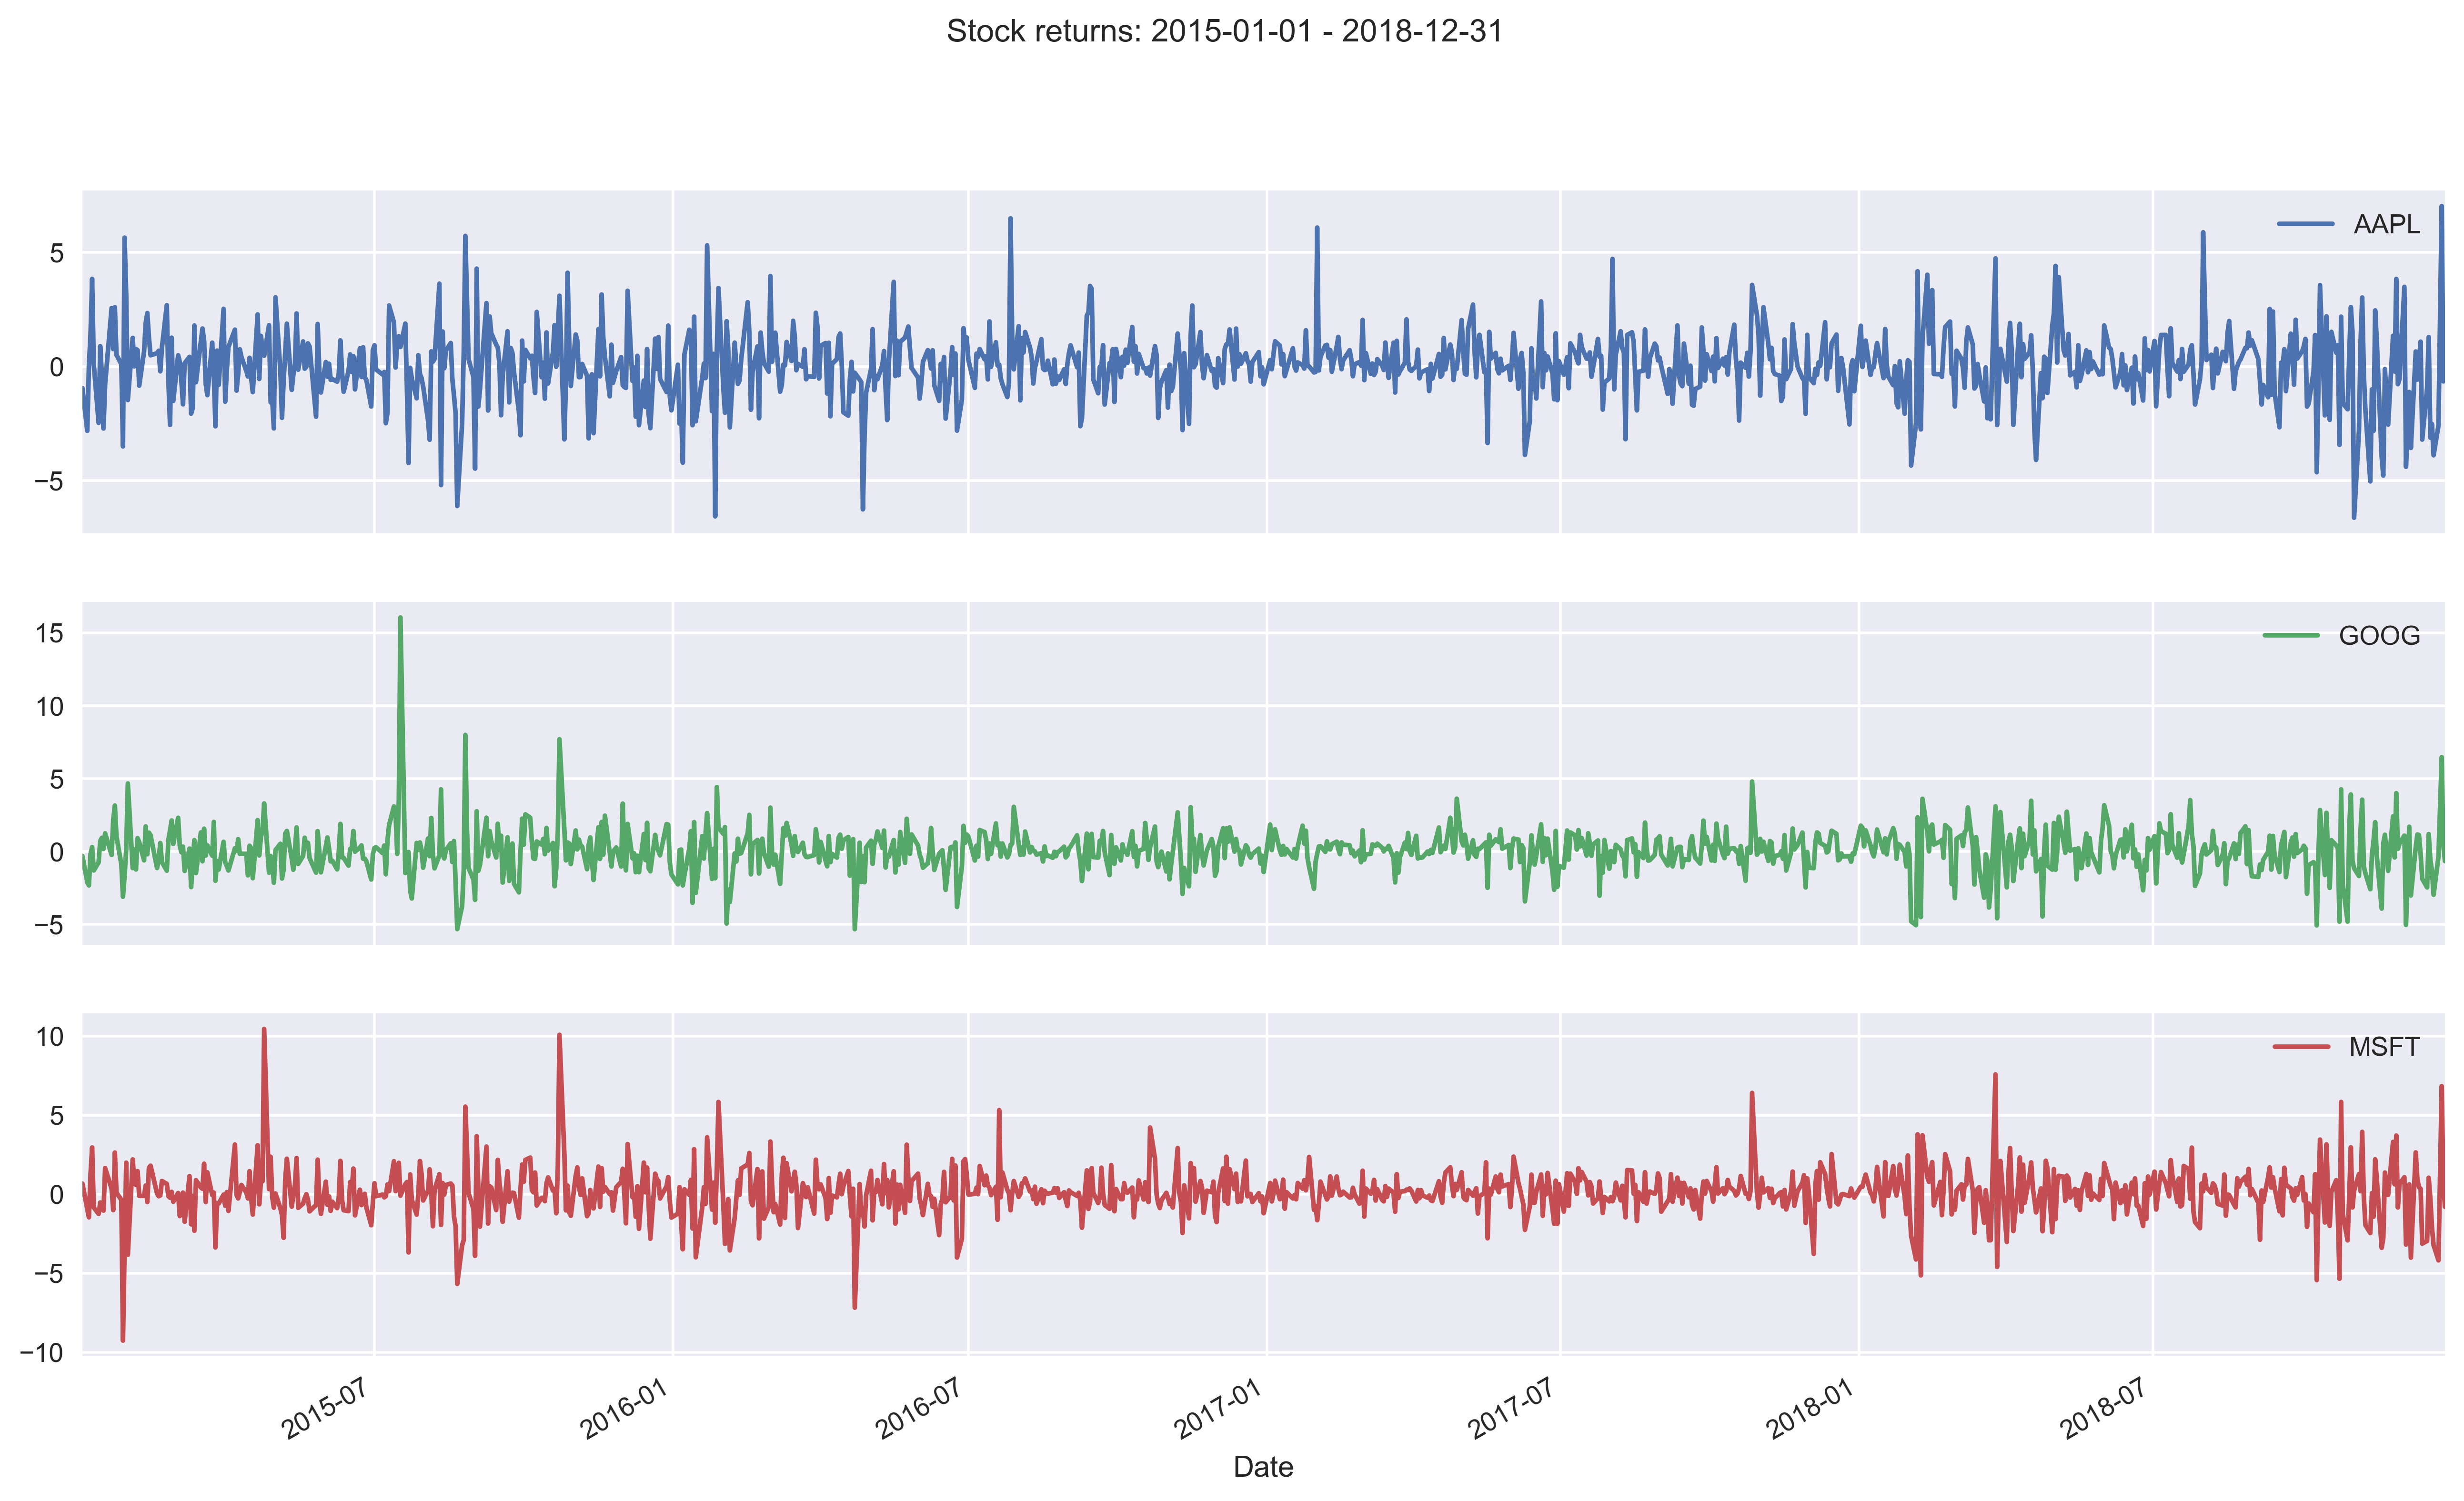

In [19]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, title=f'Stock returns: {START_DATE} - {END_DATE}');

5. Define lists for storing objects:

In [20]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

In [21]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean='Constant', vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, disp='off');
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)
    
# wrangling results for readability
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                                    .set_axis(returns.columns, axis='columns', inplace=False)
std_resids_df = pd.DataFrame(std_resids).transpose() \
                                        .set_axis(returns.columns, axis='columns', inplace=False)

In [22]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.123490,0.221521,0.126023,0.784331
GOOG,0.080484,0.193113,0.187870,0.747876
MSFT,0.119524,0.382478,0.253414,0.625803


7. Calculate the constant conditional correlation matrix (R):

In [27]:
R = std_resids_df.transpose().dot(std_resids_df).div(len(std_resids_df))

8. Calculate the 1-step ahead forecast of the conditional covariance matrix :

In [28]:
# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
# take the square root to obtain volatility from variance
diag = np.sqrt(np.array(diag))
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [29]:
H

array([[6.9923692 , 3.26973804, 3.74869208],
       [3.26973804, 6.15816126, 4.48596078],
       [3.74869208, 4.48596078, 7.56306264]])

## Forecasting the conditional covariance matrix using DCC-GARCH

### Getting ready

For details on how to easily install all the required dependencies please refer to the Appendix.

### How to do it...

1. Import the required libraries:

In [15]:
import pandas as pd

In [16]:
%load_ext rpy2.ipython

In [17]:
%watermark --iversions

numpy      1.16.2
matplotlib 3.0.3
json       2.0.9
yfinance   0.1.42
autopep8   1.4.4
pandas     0.24.2



2. Install `rmgarch` R package (run only once) and load it:

In [11]:
%%R

#install.packages('rmgarch', repos = "http://cran.us.r-project.org")
library(rmgarch)

R[write to console]: Loading required package: rugarch

R[write to console]: Loading required package: parallel

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: 
Attaching package: ‘rugarch’


R[write to console]: The following object is masked from ‘package:stats’:

    sigma




3. Import the dataset into R:

In [12]:
%%R -i returns
print(head(returns))

                           AAPL       GOOG       MSFT
2015-01-02 00:00:00 -0.94376720 -0.3028802  0.6692161
2015-01-05 00:00:00 -2.81857880 -2.0845673 -0.9259259
2015-01-06 00:00:00  0.01021242 -2.3162783 -1.4617781
2015-01-07 00:00:00  1.39895844 -0.1717973  1.2645914
2015-01-08 00:00:00  3.84692850  0.3141697  2.9538905
2015-01-09 00:00:00  0.10667184 -1.2946340 -0.8397481


4. Define the model specification:

In [13]:
%%R

# define GARCH(1,1) model
univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                              variance.model = list(garchOrder = c(1,1),
                              model = "sGARCH"),
                              distribution.model = "norm")

# define DCC(1,1) model
dcc_spec <- dccspec(uspec = multispec(replicate(dim(returns))[2], univariate_spec)),
                    dccOrder = c(1,1),
                    distribution = "mvnorm")

dcc_spec


*------------------------------*
*       DCC GARCH Spec         *
*------------------------------*
Model          :  DCC(1,1)
Estimation     :  2-step
Distribution   :  mvnorm
No. Parameters :  17
No. Series     :  3



5. Estimate the model:

In [ ]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit

6. Calculate the 5-step ahead forecasts:

In [ ]:
forecasts <- dccforecast(dcc_fit, n.ahead = 5)

7. Access the forecasts:

In [ ]:
%%R

# conditional covariance matrix
forecasts@mforecast$H
# conditional correlation matrix
forecasts@mforecast$R
# proxy correlation process
forecasts@mforecast$Q
# conditional mean forecasts
forecasts@mforecast$mu

### There's more

In [ ]:
%%R

# parallelized DCC-GARCH(1,1)

library('parallel')

# set up the cluster
cl <- makePSOCKcluster(3)

# define parallelizable specification
parallel_fit <- multifit(multispec(replicate(dim(returns)[2], univariate_spec)), 
                         returns, 
                         cluster = cl)

# fit the DCC-GARCH model
dcc_fit <- dccfit(dcc_spec, data = returns, fit.control = list(eval.se = TRUE), fit = parallel_fit, cluster = cl)

# stop the cluster
stopCluster(cl)